<a href="https://colab.research.google.com/github/timer626/Algo/blob/main/LastVersionCatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [255]:
!!pip install catboost
!!pip install optuna

['Requirement already satisfied: optuna in /usr/local/lib/python3.10/dist-packages (4.0.0)',
 'Requirement already satisfied: alembic>=1.5.0 in /usr/local/lib/python3.10/dist-packages (from optuna) (1.13.2)',
 'Requirement already satisfied: colorlog in /usr/local/lib/python3.10/dist-packages (from optuna) (6.8.2)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (from optuna) (1.26.4)',
 'Requirement already satisfied: packaging>=20.0 in /usr/local/lib/python3.10/dist-packages (from optuna) (24.1)',
 'Requirement already satisfied: sqlalchemy>=1.3.0 in /usr/local/lib/python3.10/dist-packages (from optuna) (2.0.35)',
 'Requirement already satisfied: tqdm in /usr/local/lib/python3.10/dist-packages (from optuna) (4.66.5)',
 'Requirement already satisfied: PyYAML in /usr/local/lib/python3.10/dist-packages (from optuna) (6.0.2)',
 'Requirement already satisfied: Mako in /usr/local/lib/python3.10/dist-packages (from alembic>=1.5.0->optuna) (1.3.5)',
 'Requi

In [256]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import optuna
from sklearn.model_selection import cross_val_score



In [257]:
X_train=pd.read_excel("train.xlsx")
X_test=pd.read_excel("test.xlsx")


In [258]:
X_train.sample(5)

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница
5304,5304,20220306-7492-126409374,1,20800.0,10400,Банк. карта: Банк Россия (банк. карта),2022-02-26 22:28:20,2022-03-04 16:56:54,2022-03-06 15:00:00,2,2022-03-08 12:00:00,Официальный сайт,Отмена,Номер «Стандарт»,2,2
17296,17296,20220715-7491-149448175,1,13700.0,13700,Банк. карта: Банк Россия (банк. карта),2022-07-13 20:08:16,NaT,2022-07-15 15:00:00,1,2022-07-16 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,3
17592,17592,20220104-6634-119931460,1,42800.0,0,Гарантия банковской картой,2022-01-03 21:42:53,NaT,2022-01-04 16:00:00,2,2022-01-06 12:00:00,booking.com (Booking.com),Активный,Номер «Стандарт»,2,1
718,718,20231027-7491-232302754,1,23100.0,23100,Банк. карта: Банк Россия (банк. карта),2023-10-23 19:18:51,NaT,2023-10-27 15:00:00,2,2023-10-29 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,3
22001,22001,20230715-7491-204294612,2,62400.0,31200,Банк. карта: Банк Россия (банк. карта),2023-06-11 17:41:04,2023-06-11 20:53:56,2023-07-15 15:00:00,2,2023-07-17 12:00:00,Официальный сайт,Отмена,Номер «Стандарт»,4,3


In [259]:
X_train=X_train.drop(['Unnamed: 0','№ брони'],axis=1)

In [260]:
X_test=X_test.drop(['Unnamed: 0','№ брони'],axis=1)

In [261]:
X_train.sample(2)

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница
4579,1,20100.0,0,При заселении,2023-09-06 17:58:44,NaT,2023-09-16 15:00:00,1,2023-09-17 12:00:00,Официальный сайт,Активный,Апартаменты с 2 спальнями с отдельным входом,5,1
6531,1,31540.0,31540,Отложенная электронная оплата: Банк Россия (ба...,2022-03-20 20:45:48,NaT,2022-04-01 15:00:00,2,2022-04-03 12:00:00,Бронирование из экстранета,Активный,Номер «Студия»,2,2


In [262]:
X_train['is_cancelled']=X_train['Дата отмены'].notnull().astype(int)


In [263]:
X_train['Год даты бронирования'] = X_train['Дата бронирования'].dt.year
X_train['Месяц даты бронирования'] = X_train['Дата бронирования'].dt.month
X_train['День даты бронирования'] = X_train['Дата бронирования'].dt.day
X_train['Час даты бронирования'] = X_train['Дата бронирования'].dt.hour

X_train['Год даты отмены'] = X_train['Дата отмены'].dt.year
X_train['Месяц даты отмены'] = X_train['Дата отмены'].dt.month
X_train['День даты отмены'] = X_train['Дата отмены'].dt.day
X_train['Час даты отмены'] = X_train['Дата отмены'].dt.hour

X_train['Год заезда'] = X_train['Заезд'].dt.year
X_train['Месяц заезда'] = X_train['Заезд'].dt.month
X_train['День заезда'] = X_train['Заезд'].dt.day

X_train['Год выезда'] = X_train['Выезд'].dt.year
X_train['Месяц выезда'] = X_train['Выезд'].dt.month
X_train['День выезда'] = X_train['Выезд'].dt.day



In [264]:
X_train=X_train.drop(['Дата бронирования','Дата отмены','Заезд','Выезд'],axis=1)

In [265]:
X_train['Часть предоплаты от стоимости']=X_train['Внесена предоплата']/X_train['Стоимость']

In [266]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26174 entries, 0 to 26173
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Номеров                        26174 non-null  int64  
 1   Стоимость                      26174 non-null  float64
 2   Внесена предоплата             26174 non-null  int64  
 3   Способ оплаты                  26174 non-null  object 
 4   Ночей                          26174 non-null  int64  
 5   Источник                       26174 non-null  object 
 6   Статус брони                   26174 non-null  object 
 7   Категория номера               26174 non-null  object 
 8   Гостей                         26174 non-null  int64  
 9   Гостиница                      26174 non-null  int64  
 10  is_cancelled                   26174 non-null  int64  
 11  Год даты бронирования          26174 non-null  int32  
 12  Месяц даты бронирования        26174 non-null 

In [267]:
X_train=X_train.drop(['Статус брони','Год даты отмены','Месяц даты отмены','День даты отмены','Час даты отмены'],axis=1)

In [268]:
X_train=X_train.drop(['День даты бронирования','Час даты бронирования','День заезда','День выезда'],axis=1)

In [269]:
X_train=X_train.drop(['Год заезда','Год выезда'],axis=1)

In [270]:
X_train=X_train.drop(['Стоимость','Внесена предоплата'],axis=1)

In [271]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26174 entries, 0 to 26173
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Номеров                        26174 non-null  int64  
 1   Способ оплаты                  26174 non-null  object 
 2   Ночей                          26174 non-null  int64  
 3   Источник                       26174 non-null  object 
 4   Категория номера               26174 non-null  object 
 5   Гостей                         26174 non-null  int64  
 6   Гостиница                      26174 non-null  int64  
 7   is_cancelled                   26174 non-null  int64  
 8   Год даты бронирования          26174 non-null  int32  
 9   Месяц даты бронирования        26174 non-null  int32  
 10  Месяц заезда                   26174 non-null  int32  
 11  Месяц выезда                   26174 non-null  int32  
 12  Часть предоплаты от стоимости  26174 non-null 

In [272]:
X_test['Год даты бронирования'] = X_test['Дата бронирования'].dt.year
X_test['Месяц даты бронирования'] = X_test['Дата бронирования'].dt.month
X_test['Месяц заезда'] = X_test['Заезд'].dt.month
X_test['Месяц выезда'] = X_test['Выезд'].dt.month

In [273]:
X_test=X_test.drop(['Дата бронирования','Заезд','Выезд'],axis=1)


In [274]:

X_test['Часть предоплаты от стоимости']=X_test['Внесена предоплата']/X_test['Стоимость']

In [275]:
X_test=X_test.drop(['Стоимость','Внесена предоплата'],axis=1)

In [276]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26174 entries, 0 to 26173
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Номеров                        26174 non-null  int64  
 1   Способ оплаты                  26174 non-null  object 
 2   Ночей                          26174 non-null  int64  
 3   Источник                       26174 non-null  object 
 4   Категория номера               26174 non-null  object 
 5   Гостей                         26174 non-null  int64  
 6   Гостиница                      26174 non-null  int64  
 7   is_cancelled                   26174 non-null  int64  
 8   Год даты бронирования          26174 non-null  int32  
 9   Месяц даты бронирования        26174 non-null  int32  
 10  Месяц заезда                   26174 non-null  int32  
 11  Месяц выезда                   26174 non-null  int32  
 12  Часть предоплаты от стоимости  26174 non-null 

In [277]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11218 entries, 0 to 11217
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Номеров                        11218 non-null  int64  
 1   Способ оплаты                  11218 non-null  object 
 2   Ночей                          11218 non-null  int64  
 3   Источник                       11218 non-null  object 
 4   Категория номера               11218 non-null  object 
 5   Гостей                         11218 non-null  int64  
 6   Гостиница                      11218 non-null  int64  
 7   Год даты бронирования          11218 non-null  int32  
 8   Месяц даты бронирования        11218 non-null  int32  
 9   Месяц заезда                   11218 non-null  int32  
 10  Месяц выезда                   11218 non-null  int32  
 11  Часть предоплаты от стоимости  11218 non-null  float64
dtypes: float64(1), int32(4), int64(4), object(3)
m

In [278]:
X=X_train.drop('is_cancelled',axis=1)
y=X_train['is_cancelled']
X_train1, X_val1, y_train1, y_val1 = train_test_split(X, y, test_size=0.3, random_state=42)
categorical_features = ['Способ оплаты', 'Источник','Категория номера']
# train_pool = Pool(X_train1,y_train1, cat_features=categorical_features)

In [279]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3.0,
    bagging_temperature=0.2,
    random_strength=0.5,
    grow_policy='Lossguide',
    cat_features=categorical_features,
    verbose=0,
    class_weights=[1,4]
)
model.fit(X_train1,y_train1, cat_features=categorical_features)

In [280]:
y_pred = model.predict(X_val1)
#y_pred_proba = model.predict_proba(X_val1)[:,]  # Вероятности класса 1

In [281]:
def roc_auc_curve(y, y_pred):
  # Расчет TPR, FPR и порогов
  fpr, tpr, thresholds = roc_curve(y, y_pred)

  # Расчет AUC
  roc_auc = auc(fpr, tpr)
  print('AUC:', roc_auc)

  # Визуализация ROC-кривой
  import matplotlib.pyplot as plt
  plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

AUC: 0.7778624486351636


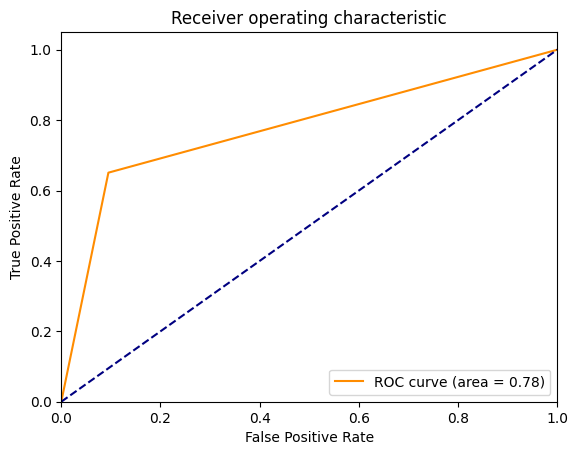

None


In [282]:
auc_roc = roc_auc_curve(y_val1, y_pred)
#73844
print(auc_roc)

In [284]:
y_onTest=model.predict(X_test)
y_onTest_df=pd.DataFrame(y_onTest)
y_onTest_df.to_csv('predictions7.csv', index=False)